# Simple Chatbot using LangGraph
Refer to github for more info: https://github.com/menloparklab/LangGraphJourney/blob/main/LangGraphLearning.ipynb

In [2]:
# Activate virtual environment
!source .venv/bin/activate

In [21]:
# Install LangGraph package
%pip install langgraph
%pip install httpx # package needed for langgraph
%pip install langchain langchain_openai
%pip install python-dotenv

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [41]:
from langgraph.graph import Graph

In [42]:
def function_1(input_1):
    return input_1 + " Hi "

def function_2(input_2):
    return input_2 + "there"

### Setting up our graph

In [43]:
workflow = Graph()

workflow.add_node("node_1", function_1)
workflow.add_node("node_2", function_2)

workflow.add_edge('node_1', 'node_2')

workflow.set_entry_point("node_1")
workflow.set_finish_point("node_2")

app = workflow.compile()

In [44]:
app.invoke("Hello")

'Hello Hi there'

### To Display our graphs
More info on displaying here: 
https://github.com/langchain-ai/langgraph/blob/main/examples/visualization.ipynb

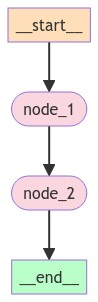

In [60]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeColors

display(
    Image(app.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)))

In [45]:
# Stream the responses so we can see the flow
input = 'Hello'
for output in app.stream(input):
    # stream() yields dictionaries with output keyed by node name
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("\n---\n")

Output from node 'node_1':
---
Hello Hi 

---

Output from node 'node_2':
---
Hello Hi there

---



### Getting API key from our .env file

In [26]:
from dotenv import load_dotenv
import os

# Load environment variables from .env file
load_dotenv()

# Now you can access your environment variables using os.environ
os.environ['OPENAI_API_KEY'] = os.environ.get("OPENAI_API_KEY")

### Creating & prompting the chatbot

In [32]:
from langchain_openai import ChatOpenAI

# Set the model as ChatOpenAI
model = ChatOpenAI(temperature=0) 

# Call the model with a user message
response = model.invoke('Hey there')
response

AIMessage(content='Hello! How can I assist you today?', response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 9, 'total_tokens': 18}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-ddd70279-5303-44f8-95d4-42b81854656d-0', usage_metadata={'input_tokens': 9, 'output_tokens': 9, 'total_tokens': 18})

##### If you want to see just the AI response

In [31]:
response.content

'Hello! How can I assist you today?'

#### Parse city mentioned

In [33]:
def function_1(input_1):
    complete_query = "Your task is to provide only the city name based on the user query. \
        Nothing more, just the city name mentioned. Following is the user query: " + input_1
    response = model.invoke(complete_query)
    return response.content

def function_2(input_2):
    return "Agent Says: " + input_2

In [34]:
# Define a Langchain graph
workflow = Graph()

#calling node 1 as agent
workflow.add_node("agent", function_1)
workflow.add_node("node_2", function_2)

workflow.add_edge('agent', 'node_2')

workflow.set_entry_point("agent")
workflow.set_finish_point("node_2")

app = workflow.compile()

In [36]:
app.invoke("What's the temperature in Las Vegas")

'Agent Says: Las Vegas'